# Tutorial - Step5 : Evaluation by comparing to SOTA models

## 1. Import requirements

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from COMA.evaluate import evaluate_metric
from COMA.properties import qed, mcs_similarity

## 2. Specify a target property

In [4]:
PROPERTY_NAME = "qed"
SCORING_FT = qed

## 3. Set directories (for inputs and outputs)

In [5]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_base_dir = os.path.abspath(os.path.join(os.pardir, "DATA", "baselines"))
input_our_dir = f"outputs_2-4_{PROPERTY_NAME.upper()}_translation"

In [6]:
output_dir = f"outputs_2-5_{PROPERTY_NAME.upper()}_evaluation"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 4. Set file names

In [7]:
filepath_train_rdkit = os.path.join(input_data_dir, "rdkit_train_pairs.txt")
filepath_test_rdkit = os.path.join(input_data_dir, "rdkit_test.txt")

In [8]:
df_pairs_rdkit = pd.read_csv(filepath_train_rdkit, header=None, sep=" ")
targets_rdkit = set(df_pairs_rdkit.iloc[:,1].values.tolist())

In [9]:
df_test_rdkit = pd.read_csv(filepath_test_rdkit, header=None, sep=" ")
df_test_rdkit.loc[:,1] = 0.

for i in tqdm.trange(len(df_test_rdkit)):
    smi = df_test_rdkit.iloc[i,0]
    score = SCORING_FT(smi)
    df_test_rdkit.iloc[i,1] = score

100%|██████████| 800/800 [00:00<00:00, 1169.98it/s]


In [10]:
src2prop = {smi:prop for smi, prop in df_test_rdkit.values}

## 5. Load translation results generated from the test dataset

In [11]:
filepath_COMA   = os.path.join(input_our_dir,  f"COMA_{PROPERTY_NAME.upper()}.csv")
filepath_JTVAE  = os.path.join(input_base_dir, f"JTVAE_{PROPERTY_NAME.upper()}.csv")
filepath_VJTNN  = os.path.join(input_base_dir, f"VJTNN_{PROPERTY_NAME.upper()}.csv")
filepath_CORE   = os.path.join(input_base_dir, f"CORE_{PROPERTY_NAME.upper()}.csv")
filepath_VJTGAN = os.path.join(input_base_dir, f"VJTNN+GAN_{PROPERTY_NAME.upper()}.csv")
filepath_HIER   = os.path.join(input_base_dir, f"HierG2G_{PROPERTY_NAME.upper()}.csv")
filepath_UGMMT  = os.path.join(input_base_dir, f"UGMMT_{PROPERTY_NAME.upper()}.csv")
filepath_HIERBT = os.path.join(input_base_dir, f"HierG2G+BT_{PROPERTY_NAME.upper()}.csv")

In [12]:
df_COMA   = pd.read_csv(filepath_COMA,   header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_JTVAE  = pd.read_csv(filepath_JTVAE,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_VJTNN  = pd.read_csv(filepath_VJTNN,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_CORE   = pd.read_csv(filepath_CORE,   header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_VJTGAN = pd.read_csv(filepath_VJTGAN, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_HIER   = pd.read_csv(filepath_HIER,   header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_UGMMT  = pd.read_csv(filepath_UGMMT,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_HIERBT = pd.read_csv(filepath_HIERBT, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})

In [13]:
frames_models = [('COMA'       , df_COMA  ),
                 ('VJTNN'      , df_VJTNN ),
                 ('VJTNN+GAN'  , df_VJTGAN),
                 ('CORE'       , df_CORE  ),
                 ('HierG2G'    , df_HIER  ),
                 ('HierG2G+BT' , df_HIERBT),
                 ('JTVAE'      , df_JTVAE ),
                 ('UGMMT'      , df_UGMMT ),]

In [14]:
for name, df in frames_models:
    df.loc[:,"PROPERTY_SRC"] = 0.
    for i in tqdm.trange(len(df)):
        smi_src = df.loc[i,"SOURCE"]
        smi_tar = df.loc[i,"TARGET"]
        df.loc[i,"PROPERTY_SRC"] = src2prop.get(smi_src)

100%|██████████| 16000/16000 [00:02<00:00, 6477.86it/s]


## 6. Evaluate metrics

In [15]:
frames_metrics = []
frames_sr = []
list_threshold_sim = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

for i in tqdm.trange(len(frames_models)):
    name, df = frames_models[i]
    res = evaluate_metric(df, targets_rdkit, num_decode=20,
                          list_threshold_sim=list_threshold_sim,
                          threshold_pro=0.9, threshold_improve=0.1)
    
    df_metrics = res['metrics']
    df_sr = res['success_rate']
    
    df_metrics.loc[:,'MODEL'] = name
    df_sr.loc[:,'MODEL'] = name
    
    frames_metrics.append(df_metrics)
    frames_sr.append(df_sr)

100%|██████████| 8/8 [00:54<00:00,  6.77s/it]


In [16]:
df_metrics_merged = pd.concat(frames_metrics, ignore_index=True)
df_sr_merged = pd.concat(frames_sr, ignore_index=True)

In [17]:
df_metrics_merged

,VALID_RATIO,PROPERTY,IMPROVEMENT,SIMILARITY,NOVELTY,DIVERSITY,MODEL
0,1.00000,0.866313,0.113545,0.343440,1.00000,0.580483,COMA
1,1.00000,0.903551,0.150783,0.307569,1.00000,0.674399,VJTNN
2,1.00000,0.897980,0.145212,0.311947,1.00000,0.682789,VJTNN+GAN
3,1.00000,0.898934,0.146166,0.317075,1.00000,0.678121,CORE
4,0.96125,0.858699,0.134659,0.270919,0.96125,0.689544,HierG2G
5,1.00000,0.905781,0.153013,0.240718,1.00000,0.772788,HierG2G+BT
6,0.92625,0.733751,0.036954,0.400449,0.92500,0.000000,JTVAE
7,0.99750,0.851116,0.100237,0.331635,0.99750,0.494688,UGMMT


In [18]:
df_sr_merged

,THRESHOLD_SIMILARITY,SR_PROP,SR_IMPR,SR_PROP_WO_NOVELTY,SR_IMPR_WO_NOVELTY,MODEL
0,0.40,0.42625,0.61375,0.42625,0.61375,COMA
1,0.45,0.33500,0.49250,0.33500,0.49250,COMA
2,0.50,0.25375,0.39375,0.25500,0.39500,COMA
3,0.55,0.17500,0.28375,0.17500,0.28375,COMA
4,0.60,0.10125,0.18125,0.10125,0.18125,COMA
5,0.65,0.04875,0.09500,0.05000,0.09500,COMA
6,0.70,0.01625,0.04375,0.01750,0.04500,COMA
7,0.40,0.55875,0.64125,0.58375,0.65625,VJTNN
8,0.45,0.42875,0.50125,0.44625,0.51375,VJTNN
9,0.50,0.30875,0.36750,0.32250,0.37750,VJTNN


In [19]:
df_metrics_merged.to_csv(os.path.join(output_dir, "table_metrics.csv"))
df_sr_merged.to_csv(os.path.join(output_dir, "table_sr.csv"))

In [20]:
def make_lineplot(df, x, y, hue, figsize=(6,4), filepath=None):
    sns.set_theme(style='darkgrid')
    
    fig, ax = plt.subplots(1,1,figsize=figsize)

    _ = sns.lineplot(data=df,
                     x=x, y=y, hue=hue,
                     style=hue, markers=True, linewidth=1, markersize=10,
                     ax=ax)

    ax.set_xlabel("Similarity threshold", fontsize=16)
    ax.set_ylabel("Success rate", fontsize=16)

    plt.tight_layout()
    if filepath is not None:
        plt.savefig(filepath, dpi=300)
    else:
        plt.show()

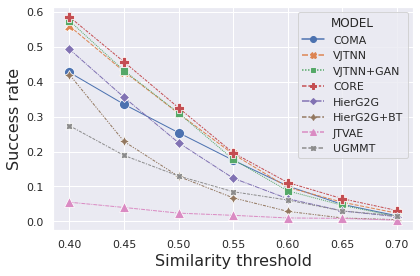

In [21]:
make_lineplot(df_sr_merged, x='THRESHOLD_SIMILARITY', y="SR_PROP", hue="MODEL",
              filepath=os.path.join(output_dir, "lineplot_SR_PROP.png"))

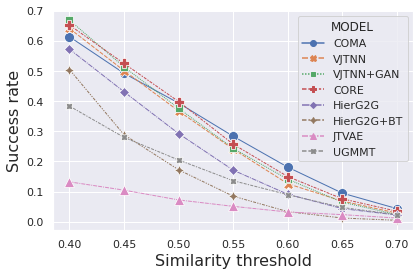

In [22]:
make_lineplot(df_sr_merged, x='THRESHOLD_SIMILARITY', y="SR_IMPR", hue="MODEL",
              filepath=os.path.join(output_dir, "lineplot_SR_IMPR.png"))

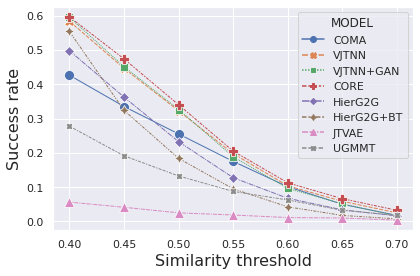

In [23]:
make_lineplot(df_sr_merged, x='THRESHOLD_SIMILARITY', y="SR_PROP_WO_NOVELTY", hue="MODEL",
              filepath=os.path.join(output_dir, "lineplot_SR_PROP_WO_NOVELTY.png"))

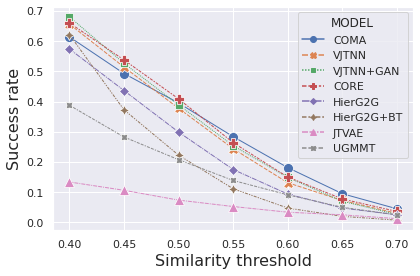

In [24]:
make_lineplot(df_sr_merged, x='THRESHOLD_SIMILARITY', y="SR_IMPR_WO_NOVELTY", hue="MODEL",
              filepath=os.path.join(output_dir, "lineplot_SR_IMPR_WO_NOVELTY.png"))

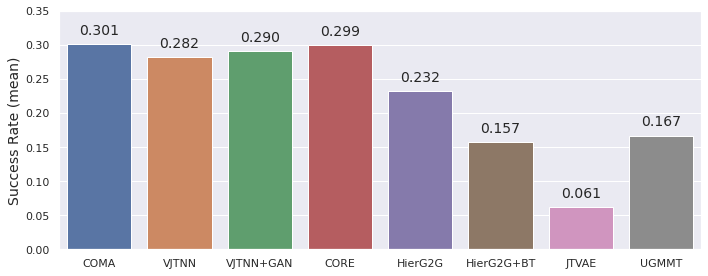

In [25]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(10,4))

_ = sns.barplot(data=df_sr_merged.groupby('MODEL').mean().reset_index(), x='MODEL', y="SR_IMPR", ax=ax, order=df_sr_merged['MODEL'].drop_duplicates())

for container in ax.containers:
    for i, bar in enumerate(container.get_children()):
        posx = i
        posy = bar.get_height() + 0.01
        ax.text(posx, posy, f"{bar.get_height():.3f}", rotation=0, ha='center', va='bottom', fontsize=14)

ax.set_xlabel(None)
ax.set_ylabel('Success Rate (mean)', fontsize=14)
ax.set_ylim(None, 0.35)
        
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "barplot_SR_IMPR_AVG.png"), dpi=300)

In [26]:
def make_radar_chart(df, figsize=(6,6), filepath=None):
    sns.set_theme(style='whitegrid')
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(polar=True)

    xticklabels = ['Validity', 'Improvement\n(normalized)', 'Similarity', 'Novelty', 'Diversity', None] # last is dummy
    xticks = np.linspace(start=0, stop=2*np.pi, num=len(xticklabels))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=16)
    
    for i in range(len(df)):
        data = [df.loc[i,"VALID_RATIO"],
                df.loc[i,"IMPROVEMENT"] / df.loc[:,"IMPROVEMENT"].max(),
                df.loc[i,"SIMILARITY"],
                df.loc[i,"NOVELTY"],
                df.loc[i,"DIVERSITY"],
                df.loc[i,"VALID_RATIO"]] # dummy that must be equal to the first
        if i == 0:
            ax.plot(xticks, data, label=df.loc[i,"MODEL"], linewidth=3)
            ax.fill(xticks, data, alpha=0.2)
        else:
            ax.plot(xticks, data, label=df.loc[i,"MODEL"], linestyle='dashed', linewidth=1.2)
    
    ax.legend(loc='lower right', ncol=1)
    plt.tight_layout()
    if filepath is not None:
        plt.savefig(filepath, dpi=300)
    else:
        plt.show()

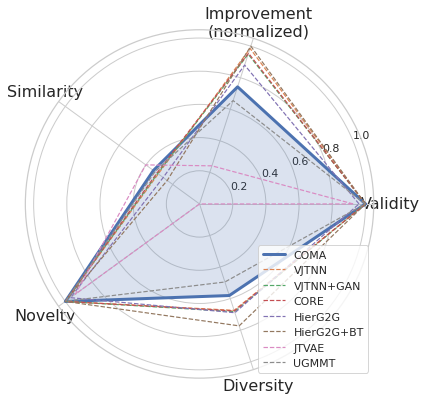

In [27]:
make_radar_chart(df_metrics_merged, filepath=os.path.join(output_dir, "radar_chart.png"))